## Green Factor

### Green Stocks Outperformance

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

etfs = {
    "IWDA.L": "market",
    "ICLN": "clean_energy",
}

symbols = list(etfs.keys())

prices_daily = (yf.download(
    tickers=symbols, 
    progress=True
  )
  .dropna()
  )

returns_daily = (prices_daily
  .stack()
  .reset_index(level=1, drop=False)
  .reset_index()
  .rename(columns={
    "Date": "date",
    "Adj Close": "adjusted"}
  )
  # transform the Ticker column into a name column, using the etfs dictionary
  .assign(name = lambda x: x["Ticker"].map(etfs),
          ret=lambda x: x.groupby("name")["adjusted"].pct_change())
    .get(["name", "date", "ret"])
    .dropna()
)


(returns_daily
  .groupby("name")["ret"]
  .describe()
  .round(3)
)

[*********************100%%**********************]  2 of 2 completed


,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
clean_energy,3736.0,0.0,0.017,-0.128,-0.009,0.0,0.009,0.114
market,3736.0,0.0,0.010,-0.106,-0.003,0.0,0.005,0.085


In [2]:
from plotnine import *
from mizani.formatters import date_format
from mizani.breaks import date_breaks

# Compute active returns as the difference between the ETF returns and the market returns
active_returns = (
    returns_daily
    .merge(
        returns_daily.query('name == "market"')[["date", "ret"]],
        on="date",
        suffixes=("", "_market"),
    )
    .assign(active_ret=lambda x: x["ret"] - x["ret_market"])
    .drop(columns=["ret_market"])
)

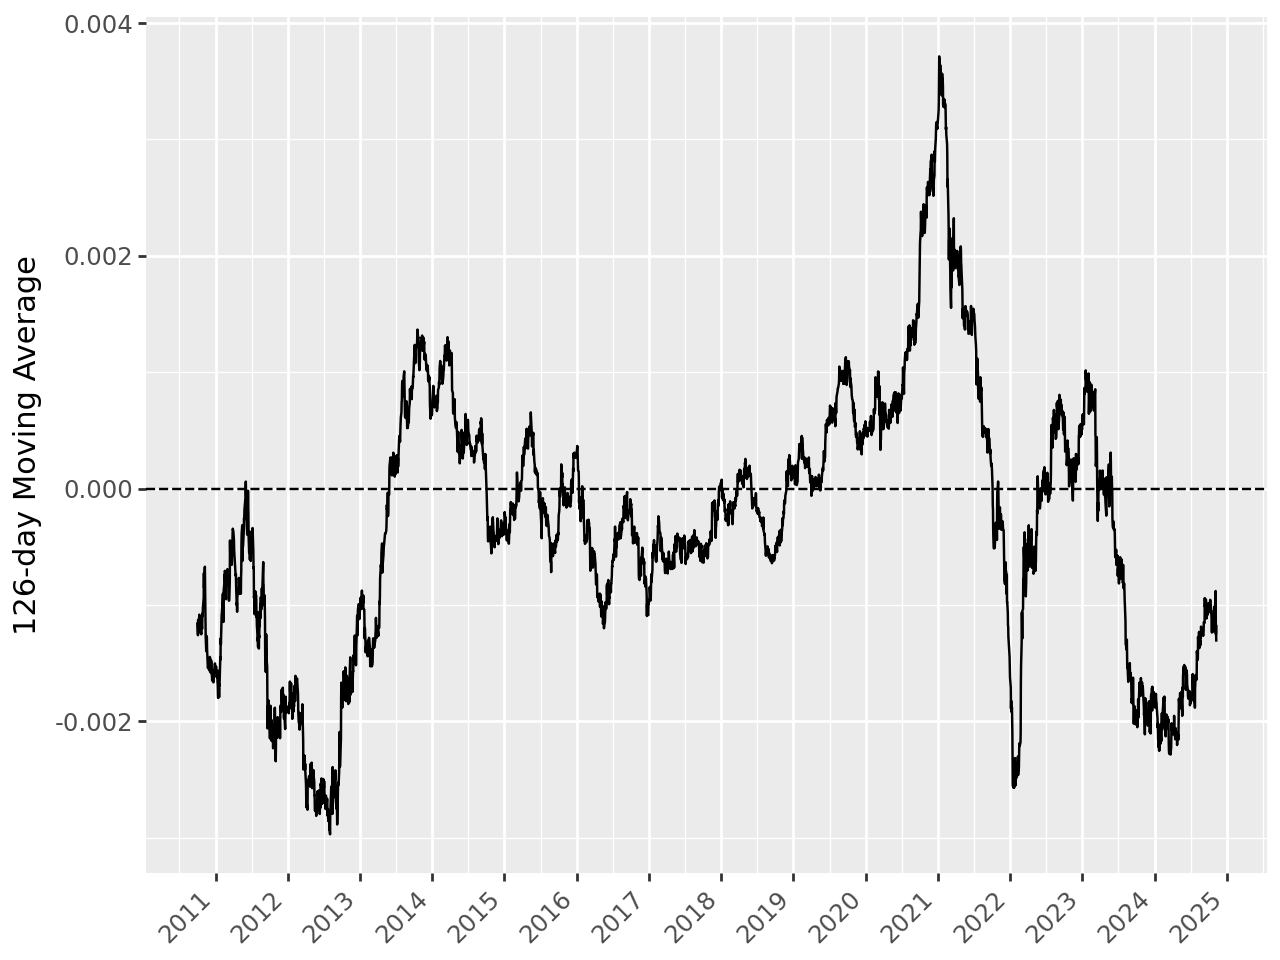

In [ ]:
# 252 day moving average

# Compute the 252-day moving average of the active returns
active_returns_ma = (
    active_returns
    .assign(
        active_ret_ma=lambda x: x.groupby("name")["active_ret"].transform(
            lambda x: x.rolling(window=252).mean()
        )
    )
    .dropna(subset=["active_ret_ma"])
    .pivot(index="date", columns="name", values="active_ret_ma")
    .get(["clean_energy"])
)

# plot the the moving average, add a horizontal line at 0
plot_ma = (
    ggplot(active_returns_ma.reset_index(), aes(x="date", y="clean_energy"))
    + geom_line()
    + geom_hline(yintercept=0, linetype="dashed")
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(
        x="",
        y="126-day Moving Average",
        title="",
        color="Name",
    )
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

plot_ma.show()


### Climate Concerns Regimes

In [ ]:
!pip install jumpmodels

#### Features Engineering

We need two inputs: (i) the returns series of our green ETF and (ii) a features dataframe.

##### Returns Series

In [18]:
ret_ser = (
    active_returns
    .pivot(index="date", columns="name", values="active_ret")
    .dropna()
    .clean_energy
)

ret_ser.head()

date
2009-09-28    0.012636
2009-09-29   -0.006282
2009-09-30    0.007348
2009-10-01   -0.026981
2009-10-02    0.003630
Name: clean_energy, dtype: float64

##### Features Dataframe

In [19]:
def compute_ewm_DD(ret_ser: pd.Series, hl: float) -> pd.Series:
    """
    Compute the exponentially weighted moving downside deviation (DD) for a return series.

    The downside deviation is calculated as the square root of the exponentially 
    weighted second moment of negative returns.

    Parameters
    ----------
    ret_ser : pd.Series
        The input return series.

    hl : float
        The halflife parameter for the exponentially weighted moving average.

    Returns
    -------
    pd.Series
        The exponentially weighted moving downside deviation for the return series.
    """
    ret_ser_neg: pd.Series = np.minimum(ret_ser, 0.)
    sq_mean = ret_ser_neg.pow(2).ewm(halflife=hl).mean()
    return np.sqrt(sq_mean)

def feature_engineer(ret_ser: pd.Series, ver: str = "v0") -> pd.DataFrame:
    """
    Engineer a set of features based on a return series.

    This function customizes the feature set according to the specified version string.

    Parameters
    ----------
    ret_ser : pd.Series
        The input return series for feature engineering.

    ver : str
        The version of feature engineering to apply. Only supports "v0".
    
    Returns
    -------
    pd.DataFrame
        The engineered feature set.
    """
    if ver == "v0":
        feat_dict = {}
        hls = [5, 20, 60]
        for hl in hls:
            # Feature 1: EWM-ret
            feat_dict[f"ret_{hl}"] = ret_ser.ewm(halflife=hl).mean()
            # Feature 2: log(EWM-DD)
            DD = compute_ewm_DD(ret_ser, hl)
            feat_dict[f"DD-log_{hl}"] = np.log(DD)
            # Feature 3: EWM-Sortino-ratio = EWM-ret/EWM-DD 
            feat_dict[f"sortino_{hl}"] = feat_dict[f"ret_{hl}"].div(DD)
        return pd.DataFrame(feat_dict)

    # try out your favorite feature sets
    else:
        raise NotImplementedError()

In [ ]:
# Apply the feature engineering function to the return series to generate the feature set
X = (ret_ser
     .pipe(feature_engineer, ver="v0")
     # replace inf values with NaN and drop them
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)
X.head()

c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log


,ret_5,DD-log_5,sortino_5,ret_20,DD-log_20,sortino_20,ret_60,DD-log_60,sortino_60
date,,,,,,,,,
2009-09-29,0.002522,-5.383127,0.549136,0.003013,-5.407995,0.672485,0.003122,-5.413704,0.700861
2009-09-30,0.004358,-5.622514,1.205403,0.004508,-5.619517,1.243191,0.004547,-5.619339,1.253665
2009-10-01,-0.005173,-4.187656,-0.340717,-0.003778,-4.255480,-0.266304,-0.003472,-4.271338,-0.248657
2009-10-02,-0.002894,-4.337465,-0.221409,-0.002192,-4.375941,-0.174287,-0.002019,-4.385823,-0.162106
2009-10-05,-0.002035,-4.467645,-0.177387,-0.001640,-4.476042,-0.144120,-0.001526,-4.479902,-0.134676


In [27]:
# Train vs. Test Split
train_start, test_start = "2009-09-29", "2022-1-1"
X_train, X_test = X[:test_start], X[test_start:]

# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

Training starts at: 2009-09-29 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-04 00:00:00 and ends at: 2024-11-08 00:00:00


The module jumpmodels.preprocess provides two classes for preprocessing: one for standardizing and one for clipping the feature data. We first clip the data within three standard deviations for all features and then perform standardization before feeding the data into the JMs. Both classes are first fitted on the training data and subsequently used to transform the test data.

These classes support both pandas DataFrames and numpy arrays as direct inputs and outputs. We prefer to retain the DataFrame type whenever possible to preserve the date index and column labels.

In [ ]:
# Preprocessing
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

clipper = DataClipperStd(mul=3.) # clip the data at 3 std. dev.
scalar = StandardScalerPD() # standardize the data
# fit on training data
X_train_processed = (X_train 
                    .pipe(clipper.fit_transform)
                    .pipe(scalar.fit_transform)
                        )
# transform the test data
X_test_processed = (
    X_test
    .pipe(clipper.transform)
    .pipe(scalar.transform)
)

               ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
date                                                                                                       
2009-09-29  0.785369 -1.209667   1.222632  1.651807  -1.870741    3.182361  2.609455  -2.341204    3.145865
2009-09-30  1.307007 -1.691953   2.861883  2.409006  -2.415690    3.182361  3.108027  -2.954295    3.145865
2009-10-01 -1.401228  1.198809  -1.000076 -1.787400   1.098509   -1.418752 -2.476150   1.064713   -2.089882
2009-10-02 -0.753650  0.896993  -0.702064 -0.984207   0.788161   -0.933680 -1.355307   0.723381   -1.326821
2009-10-05 -0.509750  0.634724  -0.592104 -0.704634   0.530271   -0.774649 -0.975759   0.442887   -1.084995


#### Jump Models

We begin by illustrating the in-sample training of the original JM. The model parameters are set as follows: the number of components/states/regimes is 2, the jump penalty 
 is 50.0, and cont=False, indicating the original discrete JM that performs hard clustering. It is important to note that the jump penalty 
 is a crucial hyperparameter that requires tuning, either through statistical criteria or cross-validation (see references for details).

SJM is implemented in the class SparseJumpModel, with an additional parameter max_feats, which controls the number of features included. This parameter roughly reflects the effective number of features. (In the notation of Nystrup et al. (2021), max_feats corresponds to 
.)

The jump penalty value is of a similar magnitude to the non-sparse model. In this case, we try max_feats=3. and jump_penalty=50.

In [103]:
from jumpmodels.jump import JumpModel                 # class of JM & CJM

# set the jump penalty
jump_penalty=50.
# initlalize the JM instance
jm = JumpModel(n_components=2, jump_penalty=jump_penalty, cont=False, )

In the .fit() call, we pass the return series for each period to be used for sorting the states. We specify sort_by="cumret", meaning that the state labels (0 or 1) are determined by the cumulative returns under each state. The state with higher cumulative returns is denoted as 
 (bull market), and the state with lower returns is denoted as 
 (bear market).

In [ ]:
# call .fit()
jm.fit(X_train_processed, ret_ser, sort_by="cumret")

AssertionError: 

The cluster centroids for each state are stored in the centers_ attribute. While these values are scaled, making direct interpretation hard, the bull market state is clearly characterized by higher returns, lower downside deviation, and a higher Sortino ratio, with a distinct separation between the two regimes.

In [110]:
print("Scaled Cluster Centroids:", pd.DataFrame(jm.centers_, index=["Bull", "Bear"], columns=X_train.columns), sep="\n" + "-"*50 + "\n")

Scaled Cluster Centroids:
--------------------------------------------------
         ret_5  DD-log_5  sortino_5    ret_20  DD-log_20  sortino_20    ret_60  DD-log_60  sortino_60
Bull  0.362805 -0.523068   0.339063  0.583241  -0.631991    0.563628  0.613667  -0.657620    0.608162
Bear -0.381203  0.549592  -0.356257 -0.612818   0.664039   -0.592209 -0.644786   0.690968   -0.639002


c:\Users\thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 251 rows containing missing values.


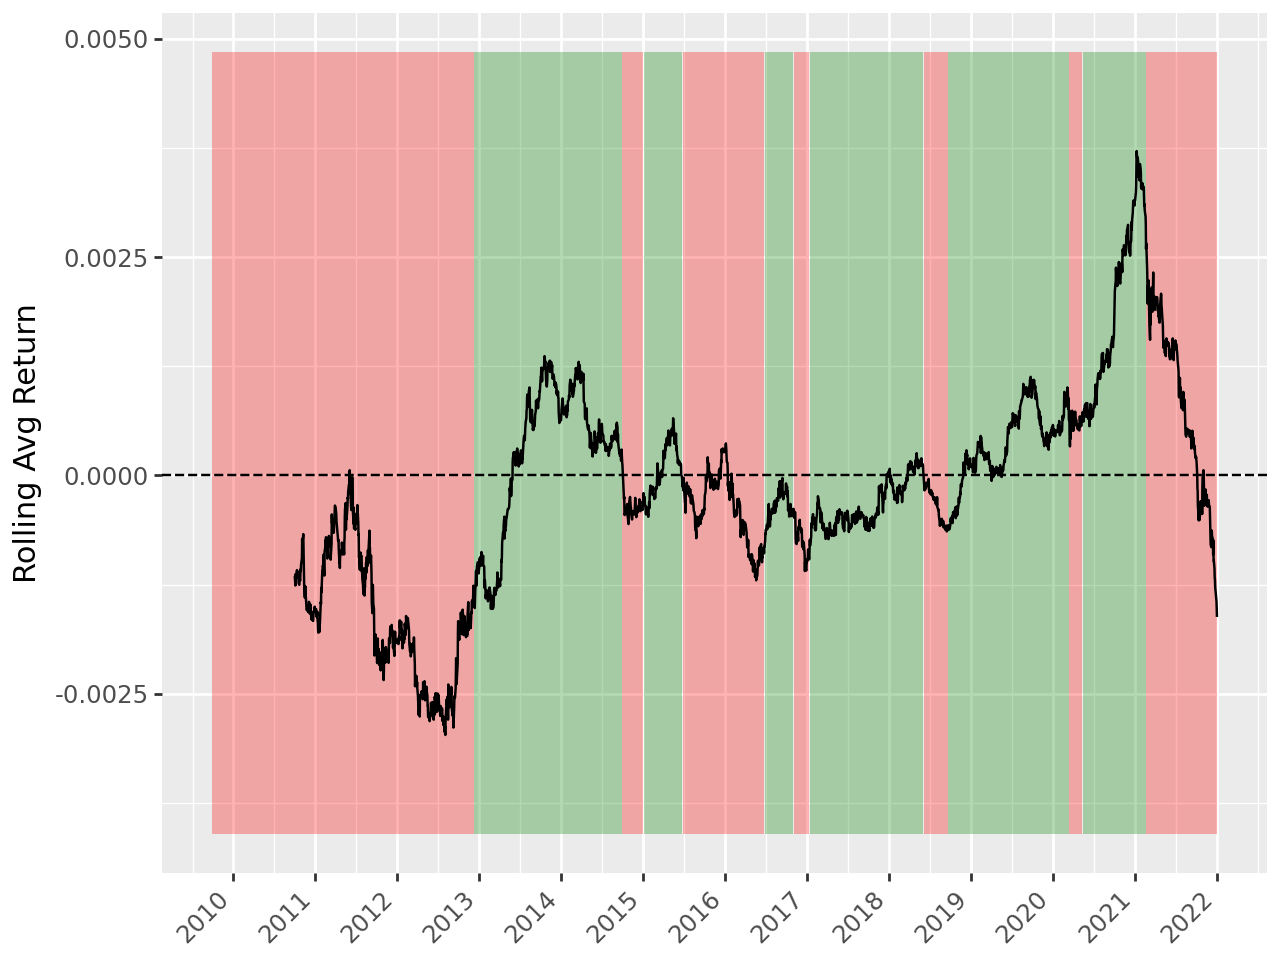

In [111]:
from plotnine import *
import pandas as pd
from mizani.formatters import date_format
from mizani.breaks import date_breaks

# Calculate the 252-day rolling average of returns
ret_ser_rolling = ret_ser.rolling(window=252).mean().reset_index()
ret_ser_rolling.columns = ["date", "rolling_avg_return"]
# restrict the rolling average to the train period
ret_ser_rolling = ret_ser_rolling.query(f'date < "{test_start}"')

# Calculate ymin and ymax based on rolling average returns data
ymin = ret_ser_rolling["rolling_avg_return"].min()
ymax = ret_ser_rolling["rolling_avg_return"].max()
std = ret_ser_rolling["rolling_avg_return"].std()

# Prepare the regimes DataFrame to get the start and end dates of each regime period
regimes = (
    jm.labels_
    .reset_index(name="regime")
    .assign(
        date=lambda x: pd.to_datetime(x["date"]),
        label=lambda x: x["regime"].map({0: "Bull", 1: "Bear"})
    )
)

# Define start and end dates for each regime type
regime_highlights = (
    regimes.groupby((regimes['label'] != regimes['label'].shift()).cumsum())
    .agg(start_date=('date', 'first'), end_date=('date', 'last'), label=('label', 'first'))
    .assign(ymin=ymin - std, ymax=ymax + std)  # Set ymin and ymax dynamically
)

# Plot regimes with rolling average line
p = (
    ggplot() +
    # Regime shaded areas using geom_rect with dynamic ymin and ymax
    geom_rect(regime_highlights, aes(
        xmin='start_date', xmax='end_date', ymin='ymin', ymax='ymax', fill='label'
    ), alpha=0.3) +
    # Rolling average line plot
    geom_line(ret_ser_rolling, aes(x='date', y='rolling_avg_return')) +
    geom_hline(yintercept=0, linetype="dashed") + 
    labs(y="Rolling Avg Return", x="") +
    scale_fill_manual(values={"Bull": "green", "Bear": "red"}) +  # Green for Bull, Red for Bear
    scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y")) +
    theme(
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position="none"  # Hide legend if it distracts from the main plot
    )
)

p.show()


#### Hyperparameter Validation

## Dynamic Allocation with Climate Regimes

### Black-Litterman Model

### Application with Climate Regimes and ETFs